###  앙상블 학습

* 앙상블 학습의 유형은 보팅, 배깅, 부스팅 세가지로 나눌 수 있으며 이외에도 스태깅을 포함한 다양한 앙상블 방법이 있다.
* 보팅의 경우 서로 다른 알고리즘을 가진 분류기를 결합하는 것이고 배깅의 경우 각각의 분류기각 모두 같은 유형의 알고리즘 기반이다.
* 정형 데이터의 예측 분석 영역에서는 매우 높은 예측 성능. Bagging 과 Boosting
* 배깅 방식의 대표인 Random Forest는 뛰어난 예측 성능, 상대적으로 빠른 수행시간, 유연성 등으로 애용.
* 부스팅의 효시는 Gradient Boosting, 한 단계 발전시키면서도 시간 단축시킨 XgBoost, LightGBM이 정형 데이터의 분류 영역에서 
  활용도 확대
* 앙상블의 앙상블이라고 불리는 스태킹 기법
* 앙상블의 기본 알고리즘은 결정 트리


Voting Classifier
- 하드 보팅: 다수결 원칙, 다수의 분류기가 결정한 예측값을 최종 보팅 결과값으로 선정
- 소프트 보팅: 분류기들의 레이블 값 결정 확률을 모두 더해서 평균하고 이들 중 가장 높은 레이블 값을 최종 보팅 결과값으로 선정

In [7]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

cancer = load_breast_cancer()
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=7)

vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)], voting='soft')
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

vo_clf.fit(X_train,y_train)
pred = vo_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print(f'Voting 분류기 정확도:{accuracy:.3f}')

classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,pred)
    class_name = classifier.__class__.__name__
    print(f'{class_name} 정확도: {accuracy:.3f}')

Voting 분류기 정확도:0.947
LogisticRegression 정확도: 0.939
KNeighborsClassifier 정확도: 0.947


Random Forest

https://eunsukimme.github.io/ml/2019/11/26/Random-Forest/


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

feature_name_df = pd.read_csv('dataset/human_activity/features.txt', sep='\s+', header=None, \
                              names = ['column_index','column_name'])
print(feature_name_df.head())
feature_name = feature_name_df.iloc[:,1].values.tolist()
print(feature_name[:10])

   column_index        column_name
0             1  tBodyAcc-mean()-X
1             2  tBodyAcc-mean()-Y
2             3  tBodyAcc-mean()-Z
3             4   tBodyAcc-std()-X
4             5   tBodyAcc-std()-Y
['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [9]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [10]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index() 
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                             'dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1])
                                                                              if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

In [11]:
def get_human_dataset():
    feature_name_df = pd.read_csv('dataset/human_activity/features.txt', sep='\s+', header=None, \
                              names = ['column_index','column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    X_train = pd.read_csv('dataset/human_activity/train/X_train.txt', sep='\s+', header=None)
    X_train.columns = feature_name
    X_test = pd.read_csv('dataset/human_activity/test/X_test.txt', sep='\s+', header=None)
    X_test.columns = feature_name
    
    y_train = pd.read_csv('dataset/human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('dataset/human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = get_human_dataset()

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

X_train, X_test, y_train, y_test = get_human_dataset()
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print(f'rf 정확도: {accuracy:.3f}')

rf 정확도: 0.925


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[50, 100],
    'max_depth' : [],
    'min_samples_leaf':[],
    'min_samples_split':[]
}

# rf 로 객체 생성 후 GridSearchCV 수행

In [13]:
from sklearn.model_selection import GridSearchCV

params= {
    'n_estimators':[50,100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}
rf_clf = RandomForestClassifier(random_state=0,n_jobs=-1)
grid_cv = GridSearchCV(rf_clf,param_grid =params,cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)

print(f'최적하이퍼파라미터: \n {grid_cv.best_params_}')
print(f'최고 예측 정확도: \n {grid_cv.best_score_}')

{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
0.9179815016322089


In [14]:
y_pred = grid_cv.best_estimator_.predict(X_test)
accuracy_test = accuracy_score(y_test , y_pred)
print('테스트 데이터에서 정확도: {0:.3f}'.format(accuracy_test))

테스트 데이터에서 정확도: 0.920


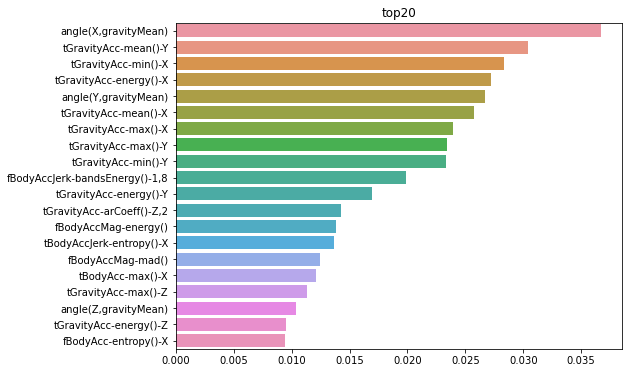

In [15]:
# 변수 중요도 시각화
import seaborn as sns
import matplotlib.pyplot as plt

best_dclf = grid_cv.best_estimator_
ftr_importances_values = best_dclf.feature_importances_

ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize = (8,6))
plt.title('top20')
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()


GBM(Gradient Boosting Machine)

- 부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 가중치 업데이트를 경사 하강법(Gradient Descent)를 이용한다.
- 분류는 물론이고 회귀도 가능
- 파라미터 : n_estimators, max_depth, max_features
 - loss : 경사하강법에서 사용할 비용함수 지정. 기본값 deviance 적용
 - learning_rate : GBM이 학습할 때마다 적용할 학습률.오류값 보정 시 적용하는 계수로 0 ~ 1 사이의 값 지정. 기본값은 0.1. 작게 설정하면 예측성능이 높아지나 수행시간이 오래 걸리고 큰 값을 적용하면 예측 성능이 떨어질 가능성이 높으나 빠른 수행이 가능. n_estimator와 상호 보완적으로 조합해 사용
 - n_estimator : weak learner의 개수
 - subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율. 기본값은 1


In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test,gb_pred)

print(f'GBM 정확도: {gb_accuracy:.3f}')
print(f'GBM 수행 시간: {time.time() - start_time}')


GBM 정확도: 0.939
GBM 수행 시간: 458.93373799324036


In [ ]:
# [과제] 상기 케이스에 대하여 성능개선을 위한 튜닝을 수행하세요.